In [1]:
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
import math
import time
from keras import backend as K
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.tree import ExtraTreeRegressor
from sklearn.metrics import r2_score
import sklearn.metrics as m
from collections import Counter
from sklearn.ensemble import ExtraTreesRegressor,RandomForestRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

Using TensorFlow backend.


In [44]:
'''
Function that takes in a dataframe and then returns the dictionary of accuracies.
'''

def plot_test(y_test,y_pred,start,end,string="trying"):
    #Plot of testing.
    plt.figure(figsize=(20,10))
    plt.plot(y_test[start:end-1],'r',linestyle="--")
    plt.plot(y_pred[start+1:end],'b')
    plt.legend()
    plt.title(string)
    plt.show()
    
def plot_bar(a,b,start,end,string="trend", overlap=0, length=20, height=10):
    #Plot of testing.
    x = np.array(list(range(214)), dtype=float)
    plt.figure(figsize=(length,height))
    if(overlap == 0):
        plt.bar(x[start:end]-0.5, a[start:end],width=0.2,color='r',align='center')
        plt.bar(x[start:end]-0.2, b[start:end],width=0.2,color='b',align='center')
    else:
        plt.bar(x[start:end], a[start:end],width=0.2,color='r',align='center')
        plt.bar(x[start:end], b[start:end],width=0.2,color='b',align='center')
    plt.title(string)
    plt.show()
    
''' plt.figure(figsize=(20,10))
    plt.plot(y_test[start:end-1],'r',linestyle="--")
    plt.plot(y_pred[start+1:end],'b')
    plt.legend()
    plt.title("Shifted")
    plt.show()
    print ("R2: ",r2_score(y_test[start:end-1],y_pred[start+1:end]))
    print ("MAE: ",mean_absolute_error(y_test[start:end-1],y_pred[start+1:end]))
    print ("RMSE: ",np.sqrt(mean_squared_error(y_test[start:end-1],y_pred[start+1:end])))
'''    
'''
    Neural net model
    ------------------------------------------
    | Arguments                              |
    ------------------------------------------
    | localdf : data                         |
    | localdict : results                    |
    | train_size : training size
    | times : number of times to perform nn  |
    | metric : metric of eval                |
    | num_cols : selection of column         |
    | hour_day : hour of the day             |
    ------------------------------------------
'''

def nn_model(ndf,times,metric,train_size,act = 'relu'):
    for counter in range(times):
        x = ndf[ndf.columns[:-1]]
        y = ndf[ndf.columns[-1]]

        #train_size = int(70*x.shape[0]/100)
        #X_train,X_test,y_train,y_test = train_test_split(x.values,y.values,test_size=0.2,random_state=1)
        X_train = x.values[:train_size]
        y_train = y.values[:train_size]

        X_test = x.values[train_size:]
        y_test = y.values[train_size:]
        
        model = Sequential()

        #Hidden Layers.
        model.add(Dense(24,input_dim=x.shape[1],kernel_initializer='normal', activation=act))
        #model.add(Dense(24,kernel_initializer='normal', activation=act))

        #Output Layer.
        model.add(Dense(1,kernel_initializer='normal',activation='linear'))

        #Compile model.
        model.compile(loss='mean_squared_error',optimizer='adam',metrics=[metric])

        #Fit the model.
        history = model.fit(X_train,y_train,epochs=750,batch_size=5,verbose=1)

        #Final Evaluation of the model.
        y_pred = model.predict(X_test,batch_size=5,verbose=1)
        y_pred[y_pred<0]=0

        r2 = r2_score(y_test,y_pred)
        rmse = np.sqrt(mean_squared_error(y_test,y_pred))
        mae = mean_absolute_error(y_test,y_pred)

        print ("R2 Score : ",r2)
        print ("RMSE : ",rmse)
        print ("MAE : ",mae)
        model.summary()
        weights1 = model.layers[0].get_weights()[0]
        biases1 = model.layers[0].get_weights()[1]
        weights2 = model.layers[1].get_weights()[0]
        biases2 = model.layers[1].get_weights()[1]
        print ("Activation used : ",act)
        plot_test(y_test,y_pred,0,100,"")
        print("y_test", y_test)
        print("y_pred", y_pred)
        del model        
    return history,y_test,y_pred,weights1, weights2, biases1, biases2 

In [3]:
'''
Testing the models on house '3273'.
'''
thermal_data = pd.read_pickle('../DataSets/New_Pecan_Street/load_data_3273.pkl')

thermal_data = thermal_data[["localhour","air1","furnace1","waterheater1"]]
thermal_data["total"] = thermal_data["air1"] + thermal_data["furnace1"] + thermal_data["waterheater1"]
thermal_data.iloc[:,[1,2,3,4]] = thermal_data.iloc[:,[1,2,3,4]].mul(1000)
thermal_data.shape

(33260, 5)

In [4]:
'''
Hourly load of house 3273 for house 3273.
'''
# 4 - 10.

summer14 = pd.DataFrame()
start = thermal_data[thermal_data["localhour"].str.contains("2014-04")].index[0]
end = thermal_data[thermal_data["localhour"].str.contains("2014-11")].index[0] - 1
summer14 = thermal_data.iloc[start:end+1]

summer15 = pd.DataFrame()
start = thermal_data[thermal_data["localhour"].str.contains("2015-04")].index[0]
end = thermal_data[thermal_data["localhour"].str.contains("2015-11")].index[0] - 1
summer15 = thermal_data.iloc[start:end+1]

summer16 = pd.DataFrame()
start = thermal_data[thermal_data["localhour"].str.contains("2016-04")].index[0]
end = thermal_data[thermal_data["localhour"].str.contains("2016-11")].index[0] - 1
summer16 = thermal_data.iloc[start:end+1]

summer17 = pd.DataFrame()
start = thermal_data[thermal_data["localhour"].str.contains("2017-04")].index[0]
end = thermal_data[thermal_data["localhour"].str.contains("2017-11")].index[0] - 1
summer17 = thermal_data.iloc[start:end+1]

'''
Winter splitting 
'''
# 11 - 3

winter14 = pd.DataFrame()
start = thermal_data[thermal_data["localhour"].str.contains("2014-11")].index[0]
end = thermal_data[thermal_data["localhour"].str.contains("2015-04")].index[0] - 1
winter14 = thermal_data.iloc[start:end+1]

winter15 = pd.DataFrame()
start = thermal_data[thermal_data["localhour"].str.contains("2015-11")].index[0]
end = thermal_data[thermal_data["localhour"].str.contains("2016-04")].index[0] - 1
winter15 = thermal_data.iloc[start:end+1]

winter15 = pd.DataFrame()
start = thermal_data[thermal_data["localhour"].str.contains("2016-11")].index[0]
end = thermal_data[thermal_data["localhour"].str.contains("2017-04")].index[0] - 1

In [37]:
'''
Converting the hourly profile into a daily load profile.
'''
def transpose_and_hours_to_day(xdf, ydf):
    nhrs = int(xdf["total"].values.shape[0]/24)
    temp_y = np.ndarray(shape=(nhrs,))
    temp_x = np.ndarray(shape=(nhrs,24))
    val = []
    val2 = []
    for i in range(nhrs):
        #Take only the loads corresponding to one whole day, starting from the hour the datframe starts from.
        val = xdf["total"].values[24*i:24*(i+1)]
        val2 = ydf["total"].values[24*i:24*(i+1)]
        temp_y[i] = np.sum(val2)
        temp_x[i]=val.T
        
    y = temp_y[1:]
    # ------------------------------------applying SAVGOL filter------------------------------
    #
    # parameters - (array to apply filter, no. of instances to consider, degree of polynomial equation used)
    y = savgol_filter(y,11,3)
    y = pd.DataFrame(y)
    y.columns = ['cur_day_load']
    print(y.shape)
    x = temp_y[:-1]
    # ------------------------------------applying SAVGOL filter------------------------------
    #
    # parameters - (array to apply filter, no. of instances to consider, degree of polynomial equation used)
    x = savgol_filter(x,11,3)
    x = pd.DataFrame(x)
    x.columns = ['prev_day_load']
    print(x.shape)
    return pd.concat([x,y],axis=1)

In [38]:
summer1 = transpose_and_hours_to_day(summer16,summer16)
summer2 = transpose_and_hours_to_day(summer15,summer15)
#summer3 = transpose_and_hours_to_day(summer14)

(167, 1)
(167, 1)
(213, 1)
(213, 1)


In [39]:
'''for summer16 use last 123 instances'''
summer1 = summer1.iloc[-123:,:]
#summer2 = summer2.iloc[-123:,:]
print(summer1.shape)
print(summer2.shape)

(123, 2)
(213, 2)


In [40]:
'''v = summer1.values[:,-1] - summer2.values[:,-1]
print(np.mean(v))'''

'v = summer1.values[:,-1] - summer2.values[:,-1]\nprint(np.mean(v))'

In [41]:
#summer1.values[:,-1] = abs(summer1.values[:,-1] - 4564.8)
summer = pd.concat([summer1,summer2],axis=0)
print (summer.shape)

(336, 2)


Epoch 1/750
123/123 [==============================] - 0s 3ms/step - loss: 97685786.0813 - mean_squared_error: 97685786.0813
Epoch 2/750
123/123 [==============================] - 0s 1ms/step - loss: 91691785.5610 - mean_squared_error: 91691785.5610
Epoch 3/750
123/123 [==============================] - 0s 1ms/step - loss: 83428435.2846 - mean_squared_error: 83428435.2846
Epoch 4/750
123/123 [==============================] - 0s 1ms/step - loss: 72166182.3415 - mean_squared_error: 72166182.3415
Epoch 5/750
123/123 [==============================] - 0s 1ms/step - loss: 57676383.2846 - mean_squared_error: 57676383.2846
Epoch 6/750
123/123 [==============================] - 0s 1ms/step - loss: 41707246.5203 - mean_squared_error: 41707246.5203
Epoch 7/750
123/123 [==============================] - 0s 1ms/step - loss: 26690259.8862 - mean_squared_error: 26690259.8862
Epoch 8/750
123/123 [==============================] - 0s 1ms/step - loss: 14823531.6789 - mean_squared_error: 14823531.6789


Epoch 134/750
123/123 [==============================] - 0s 1ms/step - loss: 436980.5288 - mean_squared_error: 436980.5288
Epoch 135/750
123/123 [==============================] - 0s 1ms/step - loss: 446023.8186 - mean_squared_error: 446023.8186
Epoch 136/750
123/123 [==============================] - 0s 2ms/step - loss: 443157.4546 - mean_squared_error: 443157.4546
Epoch 137/750
123/123 [==============================] - 0s 1ms/step - loss: 434188.6073 - mean_squared_error: 434188.6073
Epoch 138/750
123/123 [==============================] - 0s 1ms/step - loss: 436451.9975 - mean_squared_error: 436451.9975
Epoch 139/750
123/123 [==============================] - 0s 1ms/step - loss: 445234.5144 - mean_squared_error: 445234.5144
Epoch 140/750
123/123 [==============================] - 0s 1ms/step - loss: 437425.1228 - mean_squared_error: 437425.1228
Epoch 141/750
123/123 [==============================] - 0s 1ms/step - loss: 437501.9606 - mean_squared_error: 437501.9606
Epoch 142/750
12

123/123 [==============================] - 0s 1ms/step - loss: 435054.0909 - mean_squared_error: 435054.0909
Epoch 267/750
123/123 [==============================] - 0s 970us/step - loss: 435463.5262 - mean_squared_error: 435463.5262
Epoch 268/750
123/123 [==============================] - 0s 997us/step - loss: 445102.7565 - mean_squared_error: 445102.7565
Epoch 269/750
123/123 [==============================] - 0s 1ms/step - loss: 438767.7066 - mean_squared_error: 438767.7066
Epoch 270/750
123/123 [==============================] - ETA: 0s - loss: 432994.9634 - mean_squared_error: 432994.96 - 0s 1ms/step - loss: 434515.8710 - mean_squared_error: 434515.8710
Epoch 271/750
123/123 [==============================] - 0s 967us/step - loss: 453223.0676 - mean_squared_error: 453223.0676
Epoch 272/750
123/123 [==============================] - 0s 1ms/step - loss: 435644.1864 - mean_squared_error: 435644.1864
Epoch 273/750
123/123 [==============================] - 0s 983us/step - loss: 439382

123/123 [==============================] - 0s 1ms/step - loss: 437125.5185 - mean_squared_error: 437125.5185
Epoch 399/750
123/123 [==============================] - 0s 1ms/step - loss: 436997.6200 - mean_squared_error: 436997.6200
Epoch 400/750
123/123 [==============================] - 0s 1ms/step - loss: 436757.5220 - mean_squared_error: 436757.5220
Epoch 401/750
123/123 [==============================] - 0s 1ms/step - loss: 437790.4215 - mean_squared_error: 437790.4215
Epoch 402/750
123/123 [==============================] - 0s 1ms/step - loss: 437234.4794 - mean_squared_error: 437234.4794
Epoch 403/750
123/123 [==============================] - 0s 973us/step - loss: 441740.8844 - mean_squared_error: 441740.8844
Epoch 404/750
123/123 [==============================] - 0s 987us/step - loss: 435589.1813 - mean_squared_error: 435589.1813
Epoch 405/750
123/123 [==============================] - 0s 1ms/step - loss: 436114.7867 - mean_squared_error: 436114.7867
Epoch 406/750
123/123 [===

123/123 [==============================] - 0s 1ms/step - loss: 451177.0549 - mean_squared_error: 451177.0549
Epoch 531/750
123/123 [==============================] - 0s 1ms/step - loss: 441729.4823 - mean_squared_error: 441729.4823
Epoch 532/750
123/123 [==============================] - 0s 1ms/step - loss: 434623.5435 - mean_squared_error: 434623.5435
Epoch 533/750
123/123 [==============================] - 0s 1ms/step - loss: 438684.9971 - mean_squared_error: 438684.9971
Epoch 534/750
123/123 [==============================] - 0s 1ms/step - loss: 439273.8112 - mean_squared_error: 439273.8112
Epoch 535/750
123/123 [==============================] - 0s 1ms/step - loss: 438961.4229 - mean_squared_error: 438961.4229
Epoch 536/750
123/123 [==============================] - 0s 1ms/step - loss: 436428.0867 - mean_squared_error: 436428.0867
Epoch 537/750
123/123 [==============================] - 0s 1ms/step - loss: 439763.5735 - mean_squared_error: 439763.5735
Epoch 538/750
123/123 [=======

123/123 [==============================] - 0s 1ms/step - loss: 446100.2861 - mean_squared_error: 446100.2861
Epoch 663/750
123/123 [==============================] - 0s 1ms/step - loss: 441865.3884 - mean_squared_error: 441865.3884
Epoch 664/750
123/123 [==============================] - 0s 1ms/step - loss: 434052.0758 - mean_squared_error: 434052.0758
Epoch 665/750
123/123 [==============================] - 0s 986us/step - loss: 442068.8656 - mean_squared_error: 442068.8656
Epoch 666/750
123/123 [==============================] - 0s 1ms/step - loss: 442389.8500 - mean_squared_error: 442389.8500
Epoch 667/750
123/123 [==============================] - 0s 1ms/step - loss: 439538.7098 - mean_squared_error: 439538.7098
Epoch 668/750
123/123 [==============================] - 0s 1ms/step - loss: 439490.1665 - mean_squared_error: 439490.1665
Epoch 669/750
123/123 [==============================] - 0s 979us/step - loss: 443575.2660 - mean_squared_error: 443575.2660
Epoch 670/750
123/123 [===

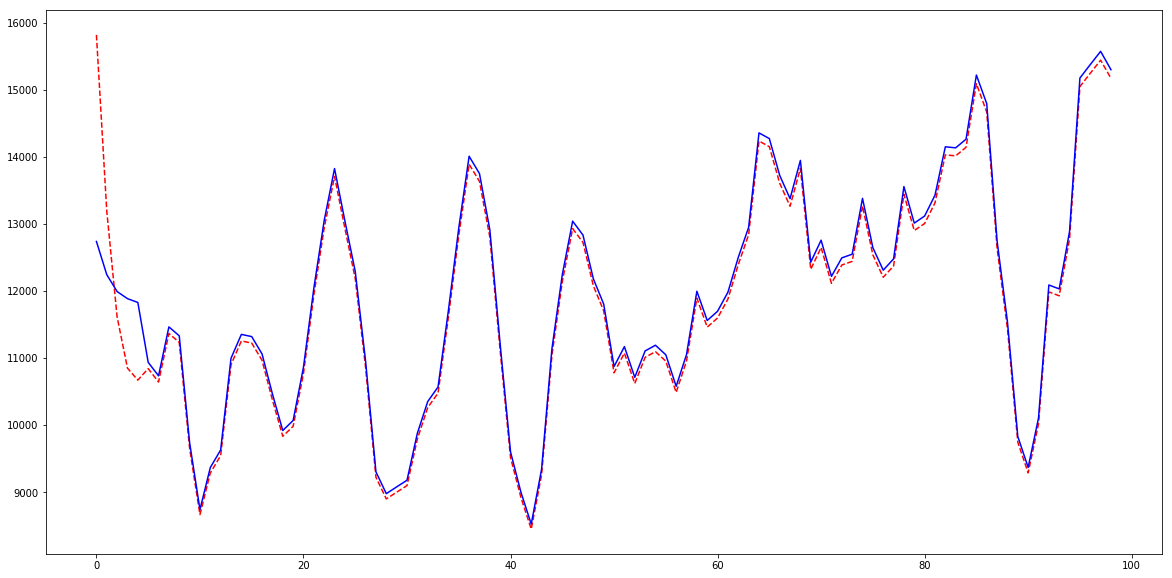

y_test [ 15815.05128205  13187.16631702  11609.05353535  10847.40192308
  10668.9004662   10840.23815074  10640.79254079  11364.35104895
  11232.10784771   9654.24553225   8663.64094794   9284.16029526
   9544.37090132  10900.02342657  11253.33034188  11220.67688423
  10963.25905206  10373.49405594   9831.71658897   9980.44250194
  10768.45714841  11935.58387723  12936.96849262  13705.43247863
  12932.21961927  12184.19386169  10856.68710179   9220.17097902
   8898.33453768   8998.21371406   9096.89296814   9791.0989899
  10259.69219114  10476.3526418   11608.07109557  12826.96177156
  13887.4504662   13631.61689977  12801.97229992  11105.16717172
   9515.86289821   8922.16565657   8448.16351981   9259.30998446
  11041.72975913  12135.88275058  12927.79848485  12721.39005439
  12075.62008547  11701.1999223   10777.99327894  11072.25804196
  10618.38752914  11008.72991453  11092.9463481   10951.51285936
  10485.69052059  10955.46515152  11891.41950272  11458.8543512
  11595.38783994  11

In [42]:
'''
Summer of house 3273.
'''
model_history,y_test,y_pred,w1,w2,b1,b2 = nn_model(summer,1,"mean_squared_error",summer1.shape[0])

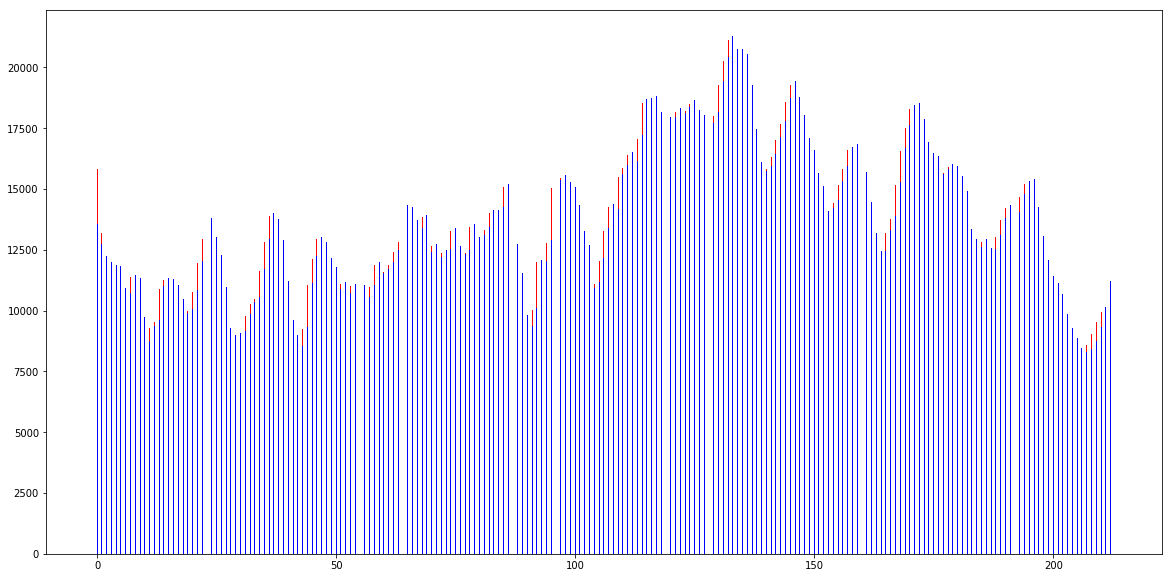

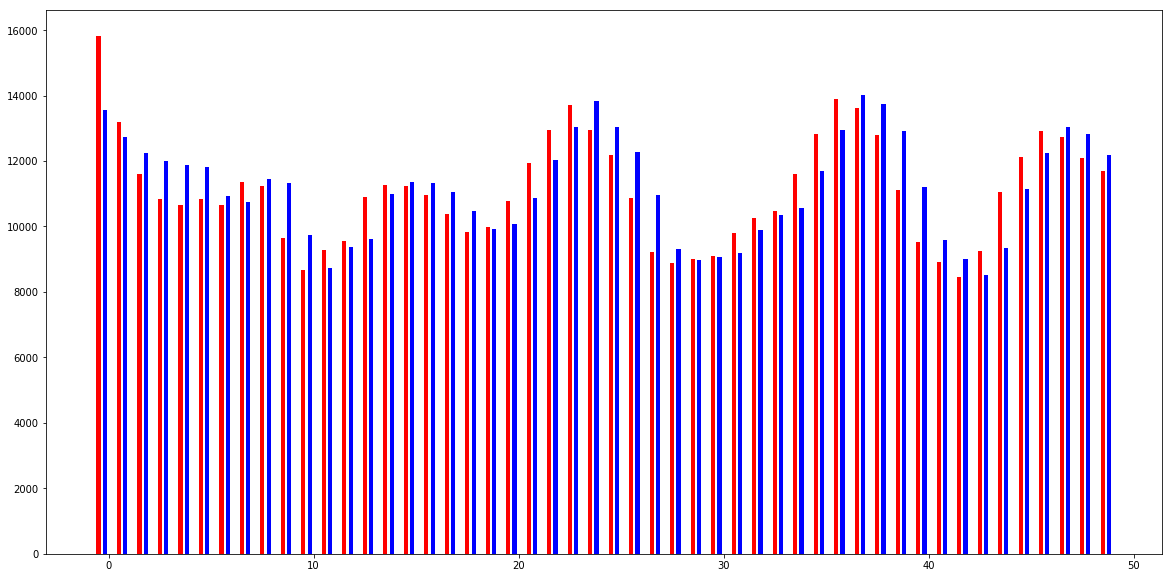

In [45]:
# finding mean error to find if the summers are always off by a certain value
# red - 1st argument
# blue - 2nd argument
'''
1st graph is just to see where all y_test is more than y_pred
2nd graph is used to compare them side by side - so give small window size for clarity
'''
plot_bar(y_test.tolist(),y_pred.T[0].tolist(),0,len(y_test),"",1)
plot_bar(y_test.tolist(),y_pred.T[0].tolist(),0,50,"")

In [ ]:
# trying to find similarities in summers
plot_bar(summer1.values[:,-1:].T[0].tolist(),summer2.values[:,-1:].T[0].tolist(),0,summer1.shape[0],"")

In [ ]:
# trying to find similarities in summers
plot_bar(summer1.values[:,-1:].T[0].tolist(),summer2.values[:,-1:].T[0].tolist(),0,summer1.shape[0],"")

In [ ]:
'''
kth nearest neighbour regressor
'''
x_train = summer1.values[:,:-1]
y_train = summer1.values[:,-1:]
neigh = KNeighborsRegressor(n_neighbors=1)
neigh.fit(x_train, y_train)
y_pred = neigh.predict(x_train)

r2 = r2_score(y_train,y_pred)
rmse = np.sqrt(mean_squared_error(y_train,y_pred))
mae = mean_absolute_error(y_train,y_pred)

print ("R2 Score : ",r2)
print ("RMSE : ",rmse)
print ("MAE : ",mae)
plot_test(y_train,y_pred,0,100,"")

In [ ]:
#extra trees
X_train = summer1.values[:,0].reshape(-1, 1) 
y_train = summer1.values[:,1]
X_test = summer2.values[:,0].reshape(-1, 1)
y_test = summer2.values[:,1]
model=ExtraTreesRegressor(n_estimators=500,max_features=None,verbose=1)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
r2 = r2_score(y_test,y_pred)
mse = mean_squared_error(y_test,y_pred)
mae = mean_absolute_error(y_test,y_pred)

print ("R2 Score : ",r2)
print ("RMSE : ",np.sqrt(mse))
print ("MAE : ",mae)

plot_test(y_test,y_pred,0,100,"")

In [ ]:
thermal_data.to_csv("df_3273.csv",sep=",",encoding="utf-8")

In [ ]:
'''
Printing the shapes of all the data files available.
'''

hid = [1037,115,2401,3268,3273,4000,6324,6614,9912]

for ti in (hid):
    print ("\n\n House : ",ti)
    df_115 = pd.read_pickle("../DataSets/New_Pecan_Street/load_data_"+str(ti)+".pkl")
    print (df_115.shape)

In [ ]:
'''
Running the model (NN) and comparing on other houses.
'''
d = {}

'''
A list containing the house-ids of the houses considered. Only one house has been dropped, due to the presence of 
NaNs in 'air1' , 'furnace1' and 'waterheater1'. 
'''
#hid = [1037,115,2401,3268,3273,4000,6324,6614,9912]
ti = time.time()
hid = [3273]

for ti in (hid):
    print ("\n\n House : ",ti)
    df_115 = pd.read_pickle("../DataSets/New_Pecan_Street/load_data_"+str(ti)+".pkl")

    df_115 = df_115[["localhour","air1","furnace1","waterheater1"]]
    df_115["total"] = df_115["air1"] + df_115["furnace1"] + df_115["waterheater1"]
    df_115.iloc[:,[1,2,3,4]] = df_115.iloc[:,[1,2,3,4]].mul(1000)
    df_115.head()
    
    '''
    Splitting the dataframe, by segmentation of data, using just the SUMMERS of all the years present.
    Summer : from May to October.
    '''
    

    # changing the shape of the given data from every row being an hour to every row being a day
    # that is, every row will now have all hours thermal load data as columns (0,1..23) in x and that day's total load in y
    # shapes being x = (1700,24), y = (1700,1)
    
    nhrs = int(df_115["total"].values.shape[0]/24)
    y_115 = np.ndarray(shape=(nhrs,))
    x_115 = np.ndarray(shape=(nhrs,24))
    val = []
    for i in range(nhrs):
        #val = df_tot_ther.values[i:i+24]
        #Take only the loads correspondin to one whole day, starting from the hour the datframe starts from.
        val = df_115["total"].values[24*i:24*(i+1)]
        y_115[i] = np.sum(val)
        x_115[i]=val.T
    y = pd.DataFrame(y_115)
    y.columns = ['day_load']
    x = pd.DataFrame(x_115)
    x.head()

    # creating the desired shape for the ANN model - 168 columns for hour-wise data of 7 days as input
    #  and next day total load as output
    temp = x.values.tolist()
    x = np.ndarray(shape=(nhrs,168))
    for i in range(7,len(temp),1):
        dlist = []
        for j in range(1,8):
            dlist = dlist + temp[i-j]
        x[i] = dlist
    x = pd.DataFrame(x)
    x.tail(10)

    x = x.iloc[7:,:]
    y = y.iloc[7:,:]
    print(x.shape)
    print(y.shape)

    d_115 = pd.concat([x,y],axis=1)
    print(d_115.shape)
    d_115.head(10)

    thermal_dict1={}
    model_history1={}
    thermal_dict1,model_history1,y_test1,y_pred1,scores,w1,w2,b1,b2 = nn_model(d_115,thermal_dict1,2,"mean_squared_error",1,0) 
    #print (thermal_dict1)
    d.setdefault(ti,[]).append(thermal_dict1)
tf=time.time()    
print ("Time Taken : ",tf-ti)

In [ ]:
print ("Dict  in 'house-id' '-' ['R^2','RMSE','MAE']: \n")
for key,val in d.items():
    print (key," - ",val,"\n")

In [ ]:
master_dict= {}
ti = time.time()
activations = ["relu","elu","selu","softplus","linear"]
for i in activations:
    thermal_dict1={}
    model_history1={}
    thermal_dict1,model_history1,y_test1,y_pred1,scores,w1,w2,b1,b2 = nn_model(d,thermal_dict1,1,"mean_squared_error",1,0,i)
    master_dict[i] = thermal_dict1
tf = time.time()
#print("\nweights",w1,"\nbiases",b1,"\nweights",w2,"\nbiases",b2)
#print("\ny_pred",y_pred1,"\ny_test",y_test1)
print (" Total Time Taken : ",tf-ti)

In [ ]:
print ("Master Dict : \n")
for key,val in master_dict.iteritems():
    print (key," - ",val,"\n\n")

In [ ]:
y

In [ ]:
master_dict= {}
ti = time.time()
activations = ["relu","elu","selu","softplus","linear"]
for i in activations:
    thermal_dict1={}
    model_history1={}
    thermal_dict1,model_history1,y_test1,y_pred1,scores,w1,w2,b1,b2 = nn_model_24(x,y,thermal_dict1,1,"mean_squared_error",1,0,i)
    master_dict[i] = thermal_dict1
tf = time.time()
#print("\nweights",w1,"\nbiases",b1,"\nweights",w2,"\nbiases",b2)
#print("\ny_pred",y_pred1,"\ny_test",y_test1)
print (" Total Time Taken : ",tf-ti)

In [ ]:
print ("Master Dict : \n")
for key,val in master_dict.iteritems():
    print (key," - ",val,"\n\n")

In [ ]:
y_test1[0],y_pred1[0]

In [ ]:
di={}
for i in range(y_test1.shape[0]):
  di[i] = abs(np.sum(y_pred1[i])-np.sum(y_test1[i]))
for key,val in di.iteritems():
    print (key," - ",val,"\n")

In [ ]:
np.mean(di.values())

In [ ]:
data = pd.read_pickle('../DataSets/New_Pecan_Street/load_data_1632.pkl')
for i in data.columns:
    if data[i].isnull().sum() >= data.values.shape[0]-10000 : del data[i]
data.columns        

In [ ]:
data = pd.DataFrame(data.values[175:],columns=data.columns)
d_localhour = data[["localhour"]]
data = data.mul(1000)
data.head()

In [ ]:
d_localhour.head()

In [ ]:
data['air1'][34492] = (data['air1'][34492-168] + data['air1'][34492+168])/2
data['air2'][34492] = (data['air2'][34492-168] + data['air2'][34492+168])/2
data['grid'][34492] = (data['grid'][34492-168] + data['grid'][34492+168])/2
data['outsidelights_plugs1'][34492] = (data['outsidelights_plugs1'][34492-168] + data['outsidelights_plugs1'][34492+168])/2
data['outsidelights_plugs2'][34492] = (data['outsidelights_plugs2'][34492-168] + data['outsidelights_plugs2'][34492+168])/2
data['refrigerator1'][34492] = 0.0
x = data.values[34492][2:]
data['use'][34492] = sum(x[1:])

In [ ]:
data.isnull().sum()

In [ ]:
df_thermal = data[['air1','air2','air3','furnace1','furnace2','waterheater1']].copy()
df_thermal['tot'] = df_thermal['air1'] + df_thermal['air2'] + df_thermal['air3'] + df_thermal['furnace1'] + df_thermal['furnace2'] + df_thermal['waterheater1']
df_tot_ther = df_thermal[['tot']]

In [ ]:
df_thermal = pd.concat([d_localhour,df_thermal],axis=1)

In [ ]:
df_tot_ther.iloc[23]

In [ ]:
df_thermal.values.tolist()[0]

In [ ]:
df_thermal.head()

In [ ]:
# changing the shape of the given data from every row being an hour to every row being a day
# that is, every row will now have all hours thermal load data as columns (0,1..23) in x and that day's total load in y
# shapes being x = (1700,24), y = (1700,1)
nhrs = int(df_tot_ther.values.shape[0]/24)
y = np.ndarray(shape=(nhrs,24))
x = np.ndarray(shape=(nhrs,24))
val = []
for i in range(nhrs):
    #val = df_tot_ther.values[i:i+24]
    #Take only the loads correspondin to one whole day, starting from the hour the datframe starts from.
    val = df_tot_ther.values[24*i:24*(i+1)]
    y[i] = val.T
    x[i]=val.T

In [ ]:
x.shape

In [ ]:
y = pd.DataFrame(y)
#y.columns = ['day_load']
x = pd.DataFrame(x)
x.head()

In [ ]:
y.head()

In [ ]:
# creating the desired shape for the ANN model - 168 columns for hour-wise data of 7 days as input
#  and next day total load as output
temp = x.values.tolist()
x = np.ndarray(shape=(nhrs,168))
for i in range(7,len(temp),1):
    dlist = []
    for j in range(1,8):
        dlist = dlist + temp[i-j]
    x[i] = dlist
x = pd.DataFrame(x)
x.tail(10)

In [ ]:
x.head(10)

In [ ]:
print (x.shape , y.shape)

In [ ]:
x = x.iloc[7:,:]
y = y.iloc[7:,:]
print(x.shape)
print(y.shape)

In [ ]:
'''
Don't run this part, when the NN model has 24 output nodes.
'''
d = pd.concat([x,y],axis=1)
print(d.shape)
d.head(10)

In [ ]:
#To check if an error is present.
sum(d.values.tolist()[0][:24]) == d.values.tolist()[0][-1]

In [ ]:
# sanity check to see if output has next day load only and inputs are all previous 7 days data
all_rows_sums = []
for i in range(d.shape[0]):
    sums = {}
    for k in range(7):
        f = d.iloc[i,24*k:24*(k+1)]
        sums['day'+str(k+1)] = sum(f)
    sums['next day tot'] = d.iloc[i,-1:]
    all_rows_sums.append(sums)
all_rows_sums

In [ ]:
x.head()

In [ ]:
y.head()

In [ ]:
#Sanity Check.
sum(x.values.tolist()[1][:24]) == sum(y.values.tolist()[0])

In [ ]:
# all  below this point not necessary for consideration...
# check the 24*7 input and next day load prediction model only till this point

In [ ]:
w_read = pd.read_csv("weather_data1.csv",dtype='object')
for i in w_read.columns:
    if w_read[i].isnull().sum() >= w_read.values.shape[0]-60000 : del w_read[i]
'''
t1 = weather['latitude'].str.contains('30.')
t2 = [c for c in range(len(t1)) if t1[c] == True]
t2[-1]
'''
w_read = pd.DataFrame(w_read.values[19495:58821], columns=w_read.columns)
w_read.isnull().sum()

In [ ]:
weather = pd.DataFrame(w_read.iloc[:,1:], columns=w_read.columns[1:])
for i in weather.columns:
    if(i!='timestamp'):
        print(i)
        weather[i] = pd.to_numeric(weather[i])
        if(weather[i].isnull().sum()!=0):
            for j in range(weather.values.shape[0]):
                if(np.isnan(weather[i][j])):
                    weather[i][j] = 0.0
weather.isnull().sum()

In [ ]:
df_tot_ther = pd.DataFrame(df_tot_ther.values[:39326], columns=df_tot_ther.columns)
weather['total_load'] = df_tot_ther[['tot']]
del weather['mean_load']

In [ ]:
weather.shape

In [ ]:
weather.tail()

In [ ]:
thermal_dict1 = {}
model_history1 = {}
ti = time.time()
thermal_dict1,model_history1,y_test1,y_pred1,scores,w1,w2,b1,b2 = nn_model(weather,thermal_dict1,1,"mean_squared_error",weather.shape[1]-1,0)
tf = time.time()
print("\nweights",w1,"\nbiases",b1,"\nweights",w2,"\nbiases",b2)
print("\ny_pred",y_pred1,"\ny_test",y_test1)
print ("Time Taken : ",tf-ti)
print (thermal_dict1)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import datetime

x = [datetime.datetime(2011, 1, 4, 0, 0),
     datetime.datetime(2011, 1, 5, 0, 0),
     datetime.datetime(2011, 1, 6, 0, 0)]
x = date2num(x)

y = [4, 9, 2]
z=[1,2,3]
k=[11,12,13]

ax = plt.subplot(111)
ax.bar(x-0.2, y,width=0.2,color='b',align='center')
ax.bar(x, z,width=0.2,color='g',align='center')
ax.bar(x+0.2, k,width=0.2,color='r',align='center')
ax.xaxis_date()

plt.show()